# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy
import math
import shap 
import tensorflow as tf
import matplotlib.pyplot as plt
import lightgbm as ltb

from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

numpy.set_printoptions(threshold=sys.maxsize)


2022-05-17 09:30:37.402230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-17 09:30:37.402264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data

df.drop(df[df.DKAPast12mos == 2].index, inplace=True)


In [5]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

166

### for DKA events prediction pre processing


In [6]:
y_label = 'DKAPast12mos' 

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [9]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[2.0, 3.0, 0.0, 1.0]

In [10]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [11]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']


df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

PtID  Pt_InitTrt  Pt_SevHypoEver  Pt_HospDKASinceDiag  Pt_NumHospDKA  \
0    3963.0         1.0             1.0                  1.0            0.0   
4   12505.0         0.0             0.0                  1.0            0.0   
7   26063.0         1.0             1.0                  1.0            0.0   
14    553.0         0.0             1.0                  1.0            0.0   
15  13365.0         0.0             0.0                  1.0            0.0   
20  15799.0         3.0             1.0                  2.0            0.0   
24  15966.0         0.0             1.0                  1.0            0.0   
27   6426.0         1.0             1.0                  0.0            1.0   
34  10659.0         0.0             1.0                  1.0            0.0   
40  19861.0         1.0             0.0                  1.0            0.0   

    Pt_InsulinRecMethod  Pt_InsLev1PerDay  Pt_InsLev2PerDay  \
0                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   
7                   0.0               0.0               0.0   
14                  1.0               0.0               0.0   
15                  0.0               0.0               0.0   
20                  1.0               0.0               0.0   
24                  0.0               0.0               0.0   
27                  0.0               0.0               0.0   
34                  0.0               0.0               0.0   
40                  0.0               0.0               0.0   

    Pt_InsLant1PerDay  Pt_InsLant2PerDay  ...  CancPancr  CancPros  CancThyr  \
0                 0.0                0.0  ...        0.0       0.0       0.0   
4                 0.0                0.0  ...        0.0       0.0       0.0   
7                 0.0                0.0  ...        0.0       0.0       0.0   
14                0.0                1.0  ...        0.0       0.0       0.0   
15                0.0                0.0  ...        0.0       0.0       0.0   
20                1.0                0.0  ...        0.0       0.0       0.0   
24                0.0                0.0  ...        0.0       0.0       0.0   
27                0.0                0.0  ...        0.0       0.0       0.0   
34                0.0                0.0  ...        0.0       0.0       0.0   
40                0.0                0.0  ...        0.0       0.0       0.0   

    CancOth  Insulin_Glargine  Insulin_Lispro  Hydrochlorothiazide  \
0       0.0               0.0             0.0                  0.0   
4       0.0               0.0             0.0                  0.0   
7       0.0               0.0             0.0                  0.0   
14      0.0               0.0             0.0                  0.0   
15      0.0               0.0             0.0                  0.0   
20      0.0               0.0             0.0                  0.0   
24      0.0               0.0             0.0                  0.0   
27      0.0               0.0             0.0                  0.0   
34      0.0               0.0             0.0                  0.0   
40      0.0               0.0             0.0                  0.0   

    Sertraline  Insulin_Aspart_Human  diagDuration  
0          0.0                   0.0       12.0876  
4          0.0                   0.0       34.1684  
7          0.0                   0.0       14.0507  
14         0.0                   0.0       20.8549  
15         0.0                   0.0       56.3915  
20         0.0                   0.0       17.1739  
24         0.0                   0.0        2.0999  
27         0.0                   0.0       10.1704  
34         0.0                   0.0       36.9979  
40         0.0                   0.0       42.6872  

[10 rows x 214 columns]

# Divide Dataset

In [12]:
df=df.drop('PtID', axis = 1)

In [13]:
# df=df.drop('PtID', axis = 1)

In [14]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [15]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


Pt_InitTrt  Pt_SevHypoEver  Pt_HospDKASinceDiag  Pt_NumHospDKA  \
0          1.0             1.0                  1.0            0.0   
4          0.0             0.0                  1.0            0.0   
7          1.0             1.0                  1.0            0.0   
14         0.0             1.0                  1.0            0.0   
15         0.0             0.0                  1.0            0.0   
20         3.0             1.0                  2.0            0.0   
24         0.0             1.0                  1.0            0.0   
27         1.0             1.0                  0.0            1.0   
34         0.0             1.0                  1.0            0.0   
40         1.0             0.0                  1.0            0.0   

    Pt_InsulinRecMethod  Pt_InsLev1PerDay  Pt_InsLev2PerDay  \
0                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   
7                   0.0               0.0               0.0   
14                  1.0               0.0               0.0   
15                  0.0               0.0               0.0   
20                  1.0               0.0               0.0   
24                  0.0               0.0               0.0   
27                  0.0               0.0               0.0   
34                  0.0               0.0               0.0   
40                  0.0               0.0               0.0   

    Pt_InsLant1PerDay  Pt_InsLant2PerDay  Pt_InsUnk  ...  CancPancr  CancPros  \
0                 0.0                0.0        0.0  ...        0.0       0.0   
4                 0.0                0.0        0.0  ...        0.0       0.0   
7                 0.0                0.0        0.0  ...        0.0       0.0   
14                0.0                1.0        0.0  ...        0.0       0.0   
15                0.0                0.0        0.0  ...        0.0       0.0   
20                1.0                0.0        0.0  ...        0.0       0.0   
24                0.0                0.0        0.0  ...        0.0       0.0   
27                0.0                0.0        0.0  ...        0.0       0.0   
34                0.0                0.0        0.0  ...        0.0       0.0   
40                0.0                0.0        0.0  ...        0.0       0.0   

    CancThyr  CancOth  Insulin_Glargine  Insulin_Lispro  Hydrochlorothiazide  \
0        0.0      0.0               0.0             0.0                  0.0   
4        0.0      0.0               0.0             0.0                  0.0   
7        0.0      0.0               0.0             0.0                  0.0   
14       0.0      0.0               0.0             0.0                  0.0   
15       0.0      0.0               0.0             0.0                  0.0   
20       0.0      0.0               0.0             0.0                  0.0   
24       0.0      0.0               0.0             0.0                  0.0   
27       0.0      0.0               0.0             0.0                  0.0   
34       0.0      0.0               0.0             0.0                  0.0   
40       0.0      0.0               0.0             0.0                  0.0   

    Sertraline  Insulin_Aspart_Human  diagDuration  
0          0.0                   0.0       12.0876  
4          0.0                   0.0       34.1684  
7          0.0                   0.0       14.0507  
14         0.0                   0.0       20.8549  
15         0.0                   0.0       56.3915  
20         0.0                   0.0       17.1739  
24         0.0                   0.0        2.0999  
27         0.0                   0.0       10.1704  
34         0.0                   0.0       36.9979  
40         0.0                   0.0       42.6872  

[10 rows x 208 columns]

In [16]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [17]:
Y.unique()

array([1., 0.])

# Feature Selection

In [18]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [19]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [20]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 150 4478]
Test -  [0. 1.] [  50 1493]


# Imputations

<AxesSubplot:>

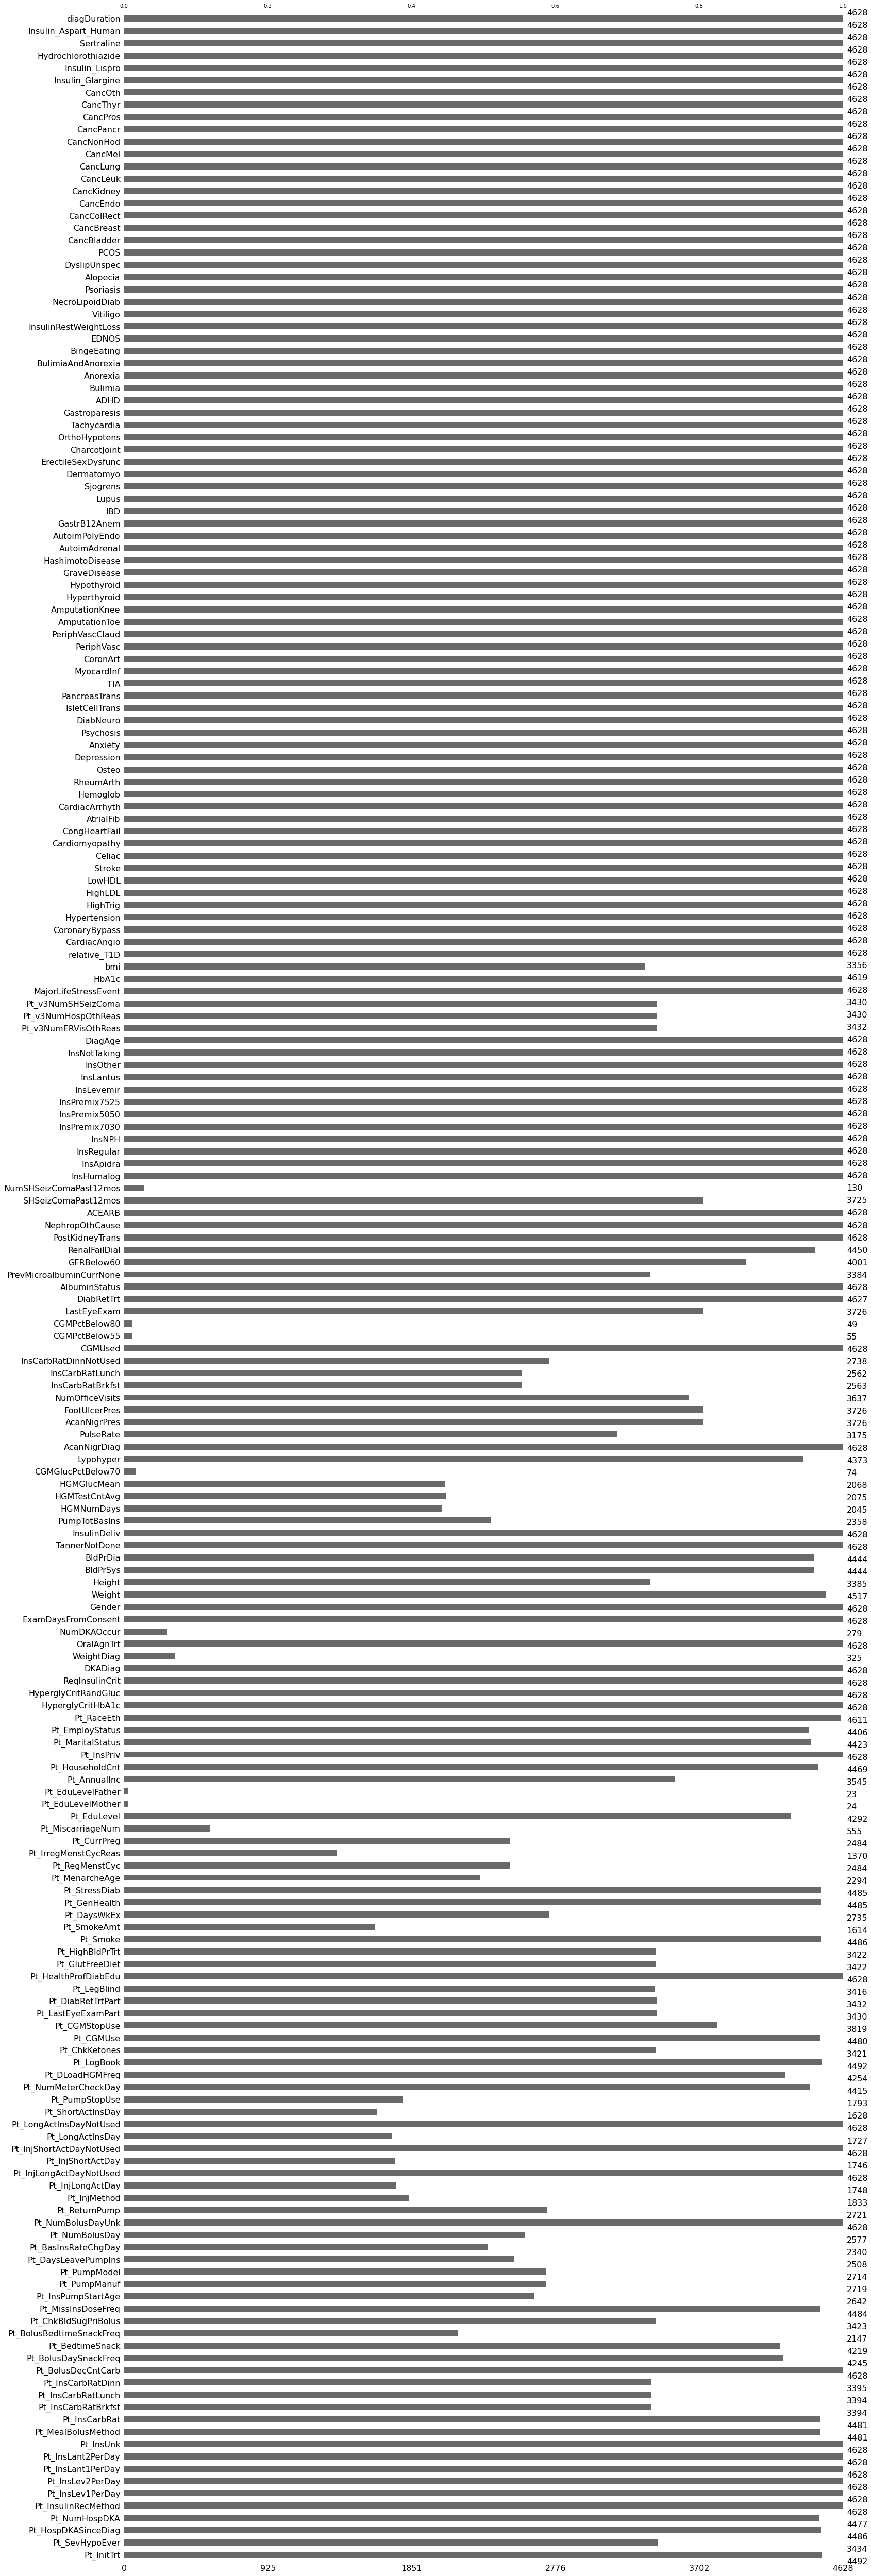

In [21]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [22]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [23]:

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumDKAOccur' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumDKAOccur'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumDKAOccur'], axis=1)
    
if('Pt_NumHospDKA' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_NumHospDKA'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_NumHospDKA'], axis=1)
    

In [24]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



def cross_val_with_missing_val(model,n_splits=5):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1

    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model


Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Accuracy for the fold no. 5 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Cross validation mean accuracy 0.967588582102621

 
 ===========   Train Dataset    =============
train ROC score 0.9426805121333929
Threshold value is: 0.950958614092025


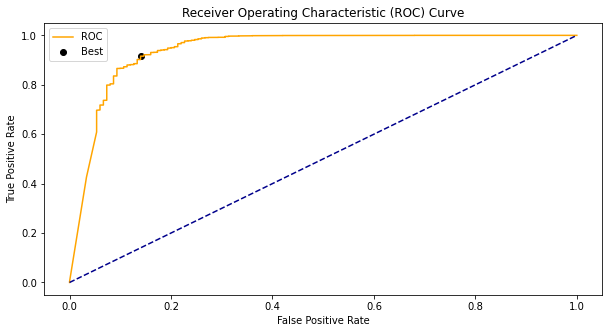

accuracy score:  91.40017286084702
              precision    recall  f1-score   support

         0.0       0.25      0.86      0.39       150
         1.0       0.99      0.92      0.95      4478

    accuracy                           0.91      4628
   macro avg       0.62      0.89      0.67      4628
weighted avg       0.97      0.91      0.94      4628



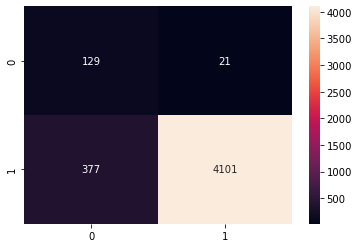

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9747037026652203


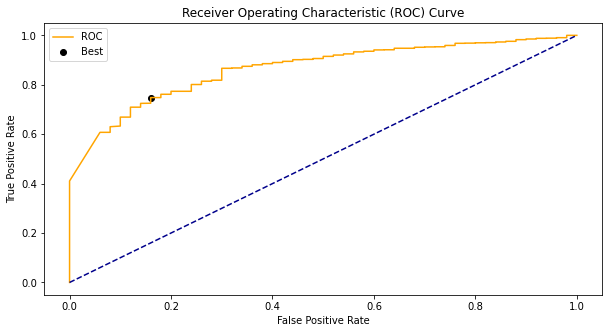

accuracy score:  75.11341542449773
              precision    recall  f1-score   support

         0.0       0.10      0.84      0.18        50
         1.0       0.99      0.75      0.85      1493

    accuracy                           0.75      1543
   macro avg       0.55      0.79      0.52      1543
weighted avg       0.96      0.75      0.83      1543



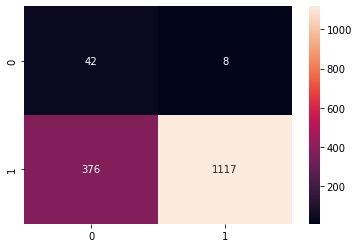

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8644


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.84       0.74815807]
average accuracy:  0.7940790354989953
f1 0.7511341542449774


In [25]:
# xgboost - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 50,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))


In [26]:
# feature importance graph of XGB
# feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
# feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 2 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 3 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 4 on the test set: 0.9686486486486486, doublecheck: 0.9686486486486486
Accuracy for the fold no. 5 on the test set: 0.9664864864864865, doublecheck: 0.9664864864864865
Cross validation mean accuracy 0.9669406339384741

 
 ===========   Train Dataset    =============
train ROC score 0.9624281673366086
Threshold value is: 2.2450154


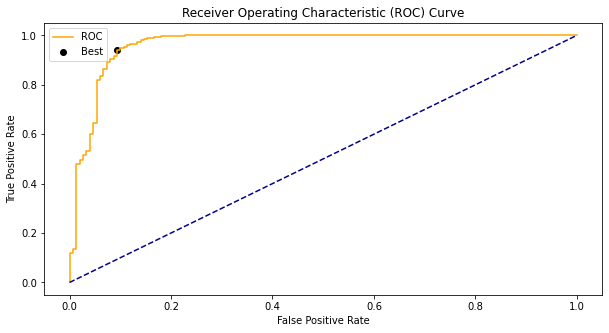

accuracy score:  94.07951598962835
              precision    recall  f1-score   support

         0.0       0.34      0.91      0.50       150
         1.0       1.00      0.94      0.97      4478

    accuracy                           0.94      4628
   macro avg       0.67      0.92      0.73      4628
weighted avg       0.98      0.94      0.95      4628



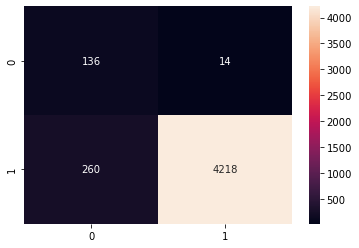

Accuracy of XGB on training set: 0.99


 ===========   Test Dataset    =============
Threshold value is: 2.9621153


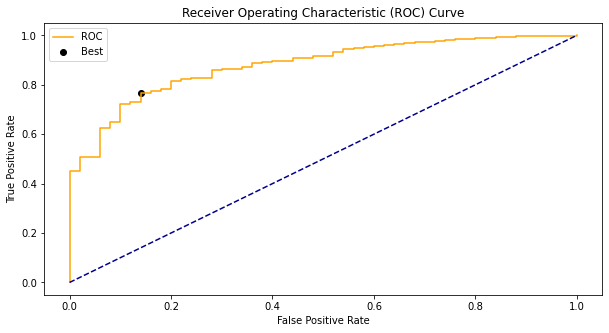

accuracy score:  76.99287103046014
              precision    recall  f1-score   support

         0.0       0.11      0.86      0.20        50
         1.0       0.99      0.77      0.87      1493

    accuracy                           0.77      1543
   macro avg       0.55      0.81      0.53      1543
weighted avg       0.97      0.77      0.84      1543



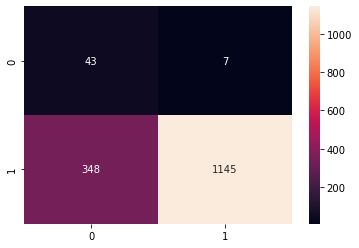

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.879


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.86       0.76691226]
average accuracy:  0.8134561286001339
f1 0.7699287103046015


In [27]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 5, #values between(3-10)
        max_delta_step = 10,
# #         scale_pos_weight = 0.4,
# #         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))



<AxesSubplot:>

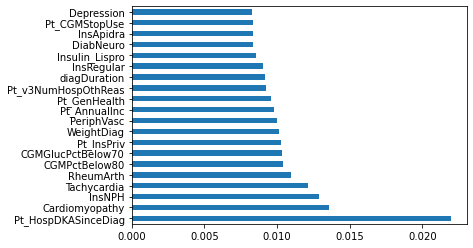

In [28]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(20).plot(kind='barh')

### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.968682505399568, doublecheck: 0.968682505399568
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 4 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Accuracy for the fold no. 5 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Cross validation mean accuracy 0.967588582102621

 
 ===========   Train Dataset    =============
train ROC score 0.9520120589548905
Threshold value is: 0.9315912948823173


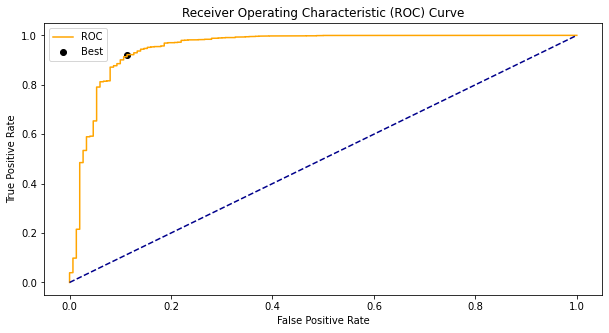

accuracy score:  92.07000864304236
              precision    recall  f1-score   support

         0.0       0.28      0.89      0.42       150
         1.0       1.00      0.92      0.96      4478

    accuracy                           0.92      4628
   macro avg       0.64      0.90      0.69      4628
weighted avg       0.97      0.92      0.94      4628



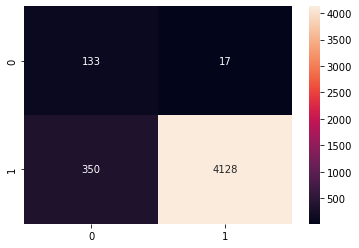

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9659720429104348


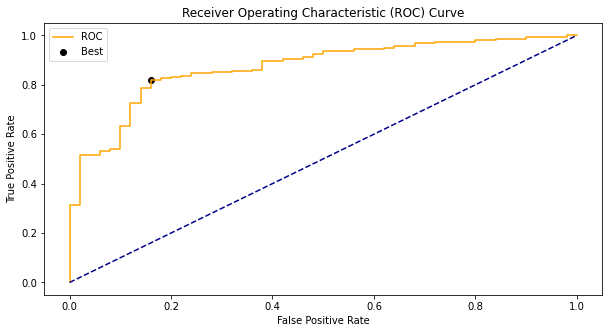

accuracy score:  82.17757615035644
              precision    recall  f1-score   support

         0.0       0.14      0.84      0.23        50
         1.0       0.99      0.82      0.90      1493

    accuracy                           0.82      1543
   macro avg       0.56      0.83      0.57      1543
weighted avg       0.97      0.82      0.88      1543



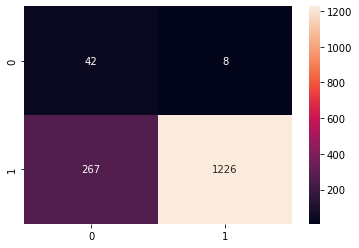

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8703


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.84       0.82116544]
average accuracy:  0.8305827193569992
f1 0.8217757615035645


In [29]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True, 
                         learning_rate = 0.03,  # 0.045 (0.03)
                         scale_pos_weight=1,
#                          is_balanced = False,
                         max_depth =4, random_state=0 ) # depth 2 to create results in thesis (3)
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))

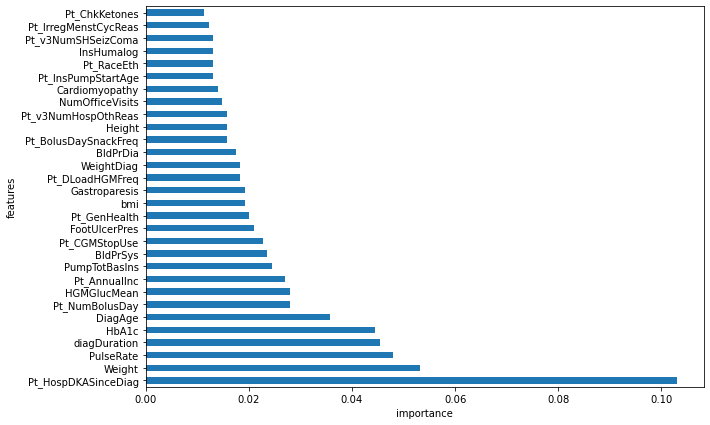

In [30]:

# feature importance graph of XGB
plt.figure(figsize=(10,7))

feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:205])
feature_importances = pd.Series((model.feature_importances_ / sum(model.feature_importances_)), index=X_train_copy.columns[0:205])
feature_importances.nlargest(30).plot(kind='barh')
plt.xlabel("importance")
plt.ylabel("features")
plt.savefig('fiDKA.png', bbox_inches='tight')

In [31]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Actual class - Positive DKA', alpha=1, color='k', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Actual class - Negative DKA', alpha=0.5, color='y', density=True)
    plt.xlabel('Predicted probability', fontsize=16)
    plt.ylabel('Number of samples in each bucket', fontsize=16)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', labelsize=14, pad=5)
    plt.savefig('dkadecisionsystembar.png', bbox_inches='tight')
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    labels = np.array(['Actual class - Positive DKA', 'Actual class - Negative DKA'])
    cs = df[y_label].to_list()
    categories = np.array(cs).astype(int)

    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    
    plt.axhline(y=thresh1, color = 'r', label='High risk threshold (T1)')
    plt.axhline(y=thresh2, color = 'g', label='Moderate risk threshold (T2)')
    
    plt.fill_between(df.x_axis_vals, y1=0.2, y2=thresh1, facecolor='red', alpha=0.1,interpolate=True)
    plt.fill_between(df.x_axis_vals, y1=thresh1, y2=thresh2, facecolor='yellow', alpha=0.1,interpolate=True)
    plt.fill_between(df.x_axis_vals, y1=thresh2, y2=1, facecolor='green', alpha=0.1,interpolate=True)
    plt.legend(fontsize=14)
    plt.xlabel('Observations', fontsize=14)
    plt.ylabel('Probability of having DKA occurences', fontsize=14)
    plt.savefig('dkaDSS.png', bbox_inches='tight')
    plt.show()

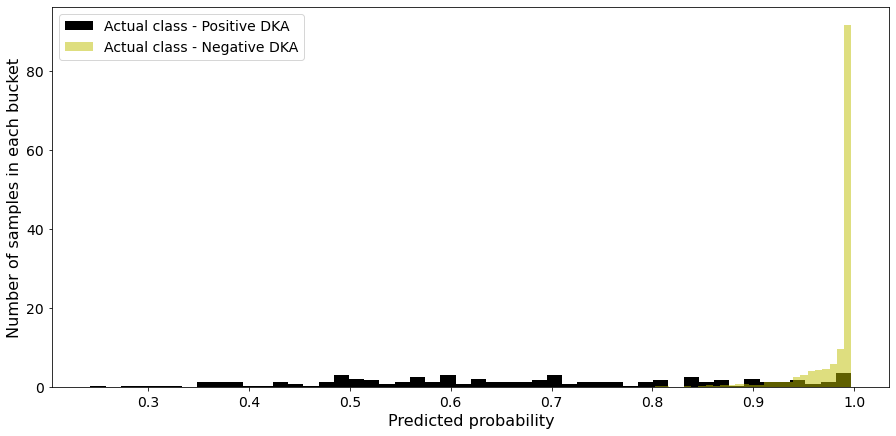

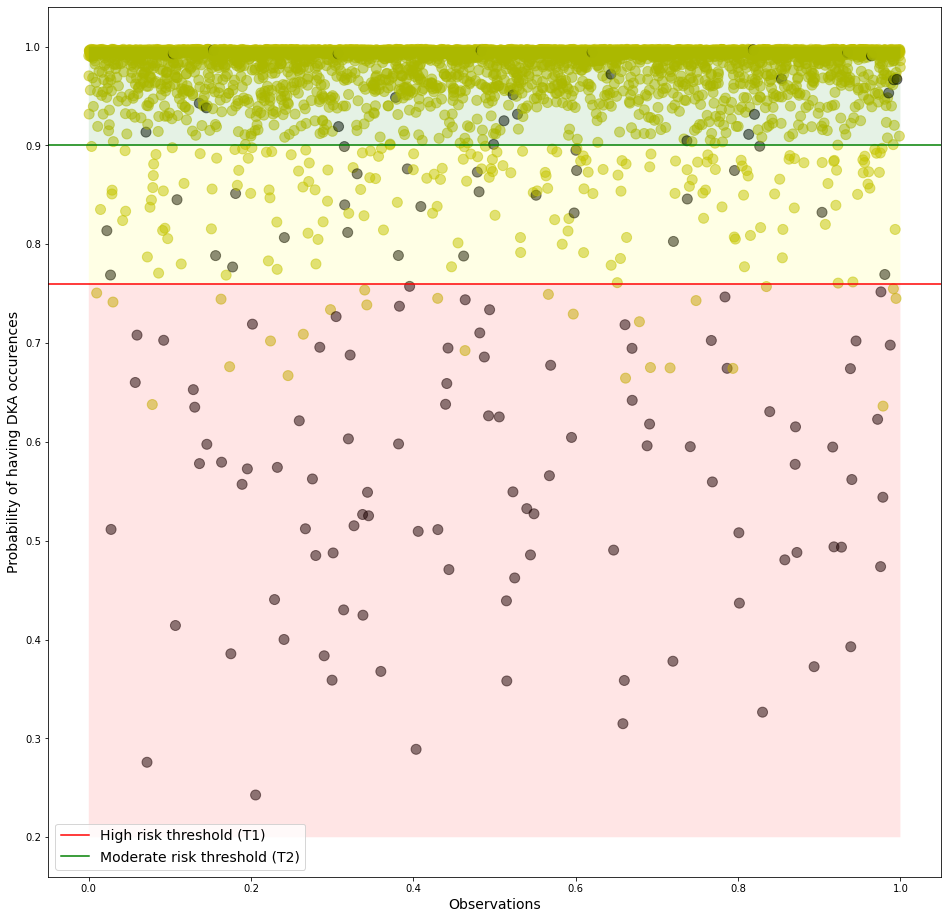

In [32]:
patients_count = X_train_copy.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.85
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(model, X_train_copy, 25000, 200)
thresh2 = 0.90
draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)

In [33]:
patients_count = X_train_copy.shape[0]
prediction = (model.predict_proba(X_train_copy)[:,1])

TP_arr = pd.DataFrame(columns=X_train_copy.columns)
FP_arr = pd.DataFrame(columns=X_train_copy.columns)
TN_arr = pd.DataFrame(columns=X_train_copy.columns)
FN_arr = pd.DataFrame(columns=X_train_copy.columns)

def get_index(prediction):
    for i, val in enumerate(prediction):
        if (val < thresh1 and Y_train.iloc[i]==0.0):
            TP_arr.loc[i] = (X_train_copy.iloc[i])
        elif (val < thresh1 and Y_train.iloc[i]==1.0):
            FP_arr.loc[i] = (X_train_copy.iloc[i])
        elif (val > thresh1 and Y_train.iloc[i]==1.0):
            TN_arr.loc[i] = (X_train_copy.iloc[i])
        elif (val > thresh1 and Y_train.iloc[i]==0.0):
            FN_arr.loc[i] = (X_train_copy.iloc[i])
get_index(prediction)
FP_arr

Pt_InitTrt  Pt_SevHypoEver  Pt_HospDKASinceDiag  Pt_InsulinRecMethod  \
45           0.0             1.0                  0.0                  0.0   
138          0.0             NaN                  0.0                  1.0   
362          0.0             1.0                  0.0                  1.0   
754          0.0             0.0                  0.0                  1.0   
803          0.0             0.0                  0.0                  0.0   
1036         1.0             NaN                  0.0                  1.0   
1136         1.0             NaN                  0.0                  0.0   
1223         1.0             1.0                  0.0                  0.0   
1378         0.0             0.0                  0.0                  1.0   
1573         0.0             NaN                  0.0                  0.0   
1585         0.0             1.0                  0.0                  0.0   
1989         0.0             NaN                  0.0                  1.0   
2145         0.0             1.0                  0.0                  0.0   
2620         0.0             NaN                  0.0                  0.0   
2762         1.0             NaN                  0.0                  0.0   
3060         0.0             0.0                  0.0                  1.0   
3139         2.0             1.0                  0.0                  1.0   
3202         0.0             0.0                  0.0                  1.0   
3314         0.0             0.0                  0.0                  0.0   
3462         1.0             0.0                  0.0                  1.0   
3672         4.0             0.0                  0.0                  1.0   
3863         2.0             NaN                  0.0                  0.0   
4528         0.0             0.0                  0.0                  0.0   
4587         1.0             0.0                  0.0                  0.0   
4602         0.0             0.0                  0.0                  1.0   

      Pt_InsLev1PerDay  Pt_InsLev2PerDay  Pt_InsLant1PerDay  \
45                 0.0               0.0                0.0   
138                0.0               0.0                0.0   
362                0.0               0.0                1.0   
754                0.0               1.0                0.0   
803                0.0               0.0                0.0   
1036               0.0               0.0                1.0   
1136               0.0               0.0                0.0   
1223               0.0               0.0                0.0   
1378               0.0               0.0                1.0   
1573               0.0               0.0                0.0   
1585               0.0               0.0                0.0   
1989               0.0               0.0                0.0   
2145               0.0               0.0                0.0   
2620               0.0               0.0                0.0   
2762               0.0               0.0                0.0   
3060               1.0               0.0                0.0   
3139               0.0               0.0                1.0   
3202               0.0               0.0                1.0   
3314               0.0               0.0                0.0   
3462               0.0               0.0                1.0   
3672               0.0               0.0                1.0   
3863               0.0               0.0                0.0   
4528               0.0               0.0                0.0   
4587               0.0               0.0                0.0   
4602               0.0               0.0                1.0   

      Pt_InsLant2PerDay  Pt_InsUnk  Pt_MealBolusMethod  ...  CancPancr  \
45                  0.0        0.0                 1.0  ...        0.0   
138                 0.0        0.0                 0.0  ...        0.0   
362                 0.0        0.0                 1.0  ...        0.0   
754                 0.0        0.0        

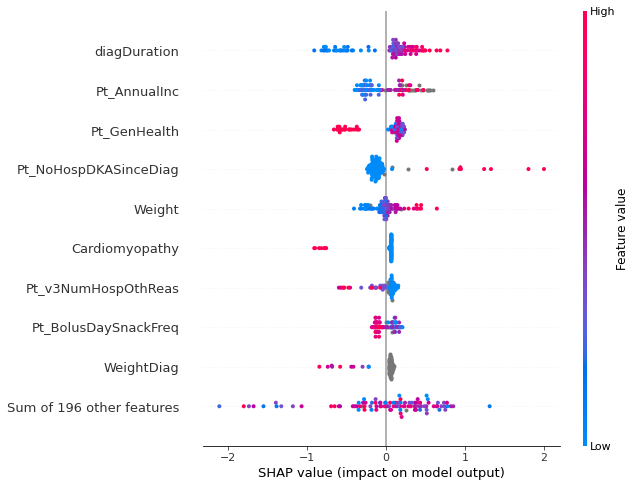

In [34]:
FP_arr.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
TP_arr.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
FP_arr.rename(columns = {'Pt_HospDKASinceDiag':'Pt_NoHospDKASinceDiag'}, inplace = True)
TP_arr.rename(columns = {'Pt_HospDKASinceDiag':'Pt_NoHospDKASinceDiag'}, inplace = True)


explainer_TP = shap.Explainer(model, TP_arr)
shap_values_TP = explainer_TP(TP_arr)

shap.plots.beeswarm(shap_values_TP, max_display=10, show=False, plot_size=[8,8])
plt.savefig('TP.png', bbox_inches='tight')

plt.show()

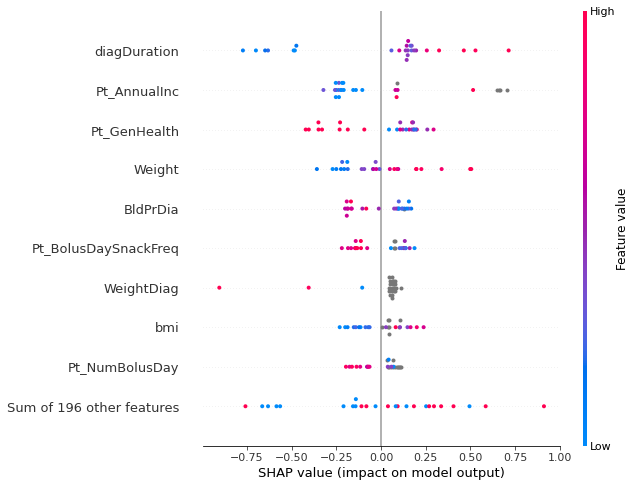

In [35]:
explainer_FP = shap.Explainer(model, FP_arr)
shap_values_FP = explainer_FP(FP_arr)

shap.plots.beeswarm(shap_values_FP, max_display=10, show=False, plot_size=[8,8])
plt.savefig('FP.png', bbox_inches='tight')

plt.show()

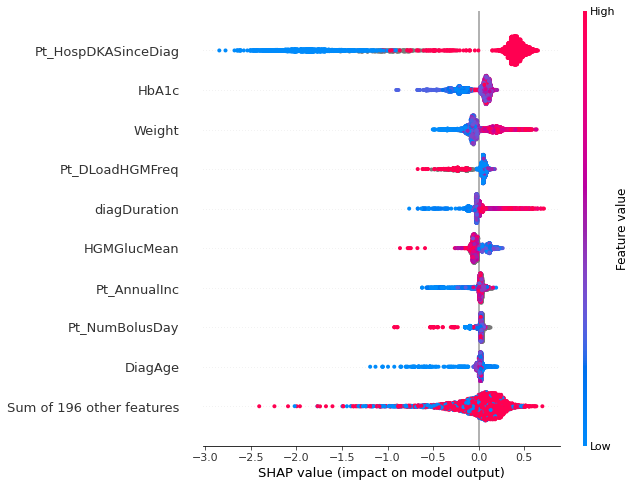

In [36]:
explainer_TN = shap.Explainer(model, TN_arr)
shap_values_TN = explainer_TN(TN_arr)

shap.plots.beeswarm(shap_values_TN, max_display=10, show=False, plot_size=[8,8])

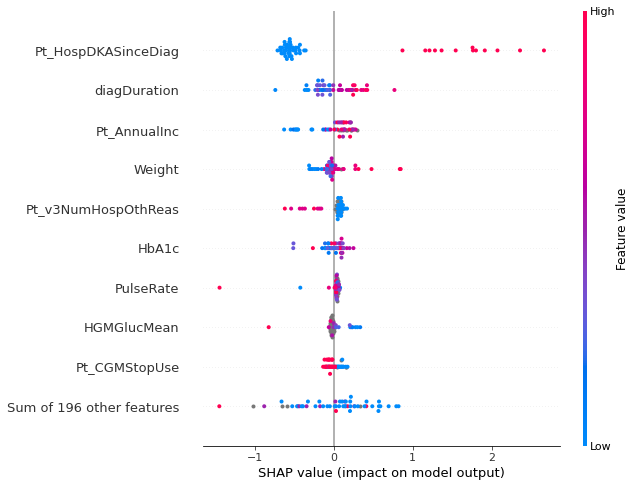

In [37]:
explainer_FN = shap.Explainer(model, FN_arr)
shap_values_FN = explainer_FN(FN_arr)

shap.plots.beeswarm(shap_values_FN, max_display=10, show=False, plot_size=[8,8])

In [38]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [39]:
for i in range(500):
    data_for_prediction = X_test_copy.iloc[i]
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

    pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
    if (pred == Y_test.iloc[i] and pred == 0.0):
        print(i)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it wi

43
98
131
136
192
197
246
261
263
282
322
363
440
465
487
495


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it wi

In [40]:
X_test_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
X_train_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
X_test_copy.rename(columns = {'Pt_HospDKASinceDiag':'Pt_NoHospDKASinceDiag'}, inplace = True)
X_train_copy.rename(columns = {'Pt_HospDKASinceDiag':'Pt_NoHospDKASinceDiag'}, inplace = True)



row_to_show = 98
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
# import matplotlib.pyplot as pl
# shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit', show=False, matplotlib=True)
# plt.savefig('dkalocal.png' ,bbox_inches='tight')


# shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit')
# plt.savefig('dkalocal.png' ,bbox_inches='tight')

f=shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction,
                link='logit')

shap.save_html("index.html", f)


sv = shap_values[0][0,:]

mapping = dict(zip(X_train_copy.columns.tolist(), list(data_for_prediction)))
data = list(mapping.values())
key = list(mapping.keys())
arr = []

for i, val in enumerate(key):
    a = val+'='+ str(data[i])
    arr.append(a)

new_sv = []
new_arr = []
for i, val in enumerate(sv):
    isRange = False
    if((0. <= sv[i] <= 0.015) or (0.0 >= sv[i] >= -0.015)):
        isRange = True
    if(sv[i] != 0. and not isRange ):
        new_sv.append(sv[i])
        new_arr.append(arr[i])

print(new_sv)
print(new_arr)

predictoin [0]
actial 0.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[1.7872357670180448, 0.018643404994301394, -0.04475159539230534, -0.03780478233780784, 0.0171437375636516, -0.019152363339145464, 0.033794176260689986, -0.10069301576133523, 0.019735176618039706, -0.022997475552060026, -0.16564020466696044, -0.035958201989170345, -0.024973713958486722, 0.2258686046337128, -0.023020079704581614, 0.053840468399266, -0.01730225034903124, 0.03153332354654161, 0.15001957444193847, 0.025358314176372732, 0.04217792969487209, 0.03679546449943038, -0.020232139780165262, -0.02156879796774208, 0.06319396830569508]
['Pt_NoHospDKASinceDiag=0.0', 'Pt_MealBolusMethod=0.0', 'Pt_BolusDaySnackFreq=2.0', 'Pt_InsPumpStartAge=48.0', 'Pt_BasInsRateChgDay=4.0', 'Pt_DLoadHGMFreq=1.0', 'Pt_ChkKetones=nan', 'Pt_CGMStopUse=0.0', 'Pt_HealthProfDiabEdu=1.0', 'Pt_GenHealth=1.0', 'Pt_AnnualInc=6.0', 'Pt_InsPriv=1.0', 'WeightDiag=nan', 'Weight=59.2', 'Height=nan', 'BldPrSys=154.0', 'BldPrDia=72.0', 'HGMTestCntAvg=4.0', 'HGMGlucMean=306.0', 'NumOfficeVisits=nan', 'AlbuminStatus=1.0', 

In [41]:
sorted_arr = [x for _,x in sorted(zip(new_sv,new_arr), reverse=True)]
print(sorted_arr)
sorted_sv = sorted(new_sv, reverse=True)

['Pt_NoHospDKASinceDiag=0.0', 'Weight=59.2', 'HGMGlucMean=306.0', 'diagDuration=16.8179', 'BldPrSys=154.0', 'AlbuminStatus=1.0', 'DiagAge=37.0', 'Pt_ChkKetones=nan', 'HGMTestCntAvg=4.0', 'NumOfficeVisits=nan', 'Pt_HealthProfDiabEdu=1.0', 'Pt_MealBolusMethod=0.0', 'Pt_BasInsRateChgDay=4.0', 'BldPrDia=72.0', 'Pt_DLoadHGMFreq=1.0', 'Pt_v3NumHospOthReas=nan', 'DiabNeuro=0.0', 'Pt_GenHealth=1.0', 'Height=nan', 'WeightDiag=nan', 'Pt_InsPriv=1.0', 'Pt_InsPumpStartAge=48.0', 'Pt_BolusDaySnackFreq=2.0', 'Pt_CGMStopUse=0.0', 'Pt_AnnualInc=6.0']


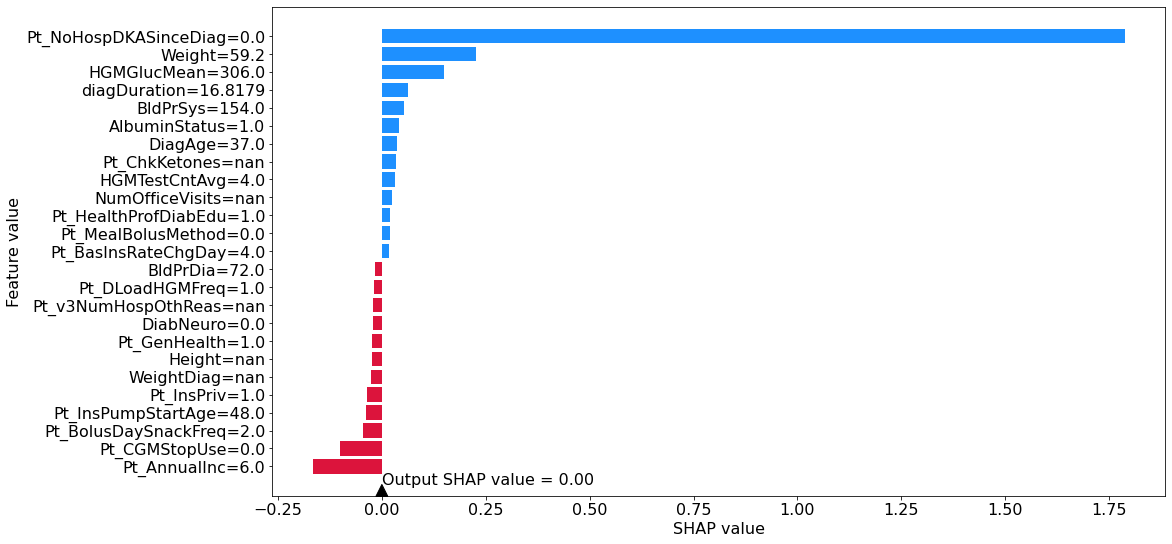

In [42]:
threshold = 0.00

plt.rcParams.update({'font.size': 16})

color = ['dodgerblue' if e >= 0 else 'crimson' for e in sorted_sv]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(sorted_arr, sorted_sv, color=color, left = threshold)

ax.annotate('Output SHAP value = 0.00', xy=(threshold,25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Show top values
ax.invert_yaxis()
plt.xlabel('SHAP value', fontsize=16)
plt.ylabel('Feature value', fontsize=16)
plt.savefig('DKAlocalNew.png' ,bbox_inches='tight')

# Show Plot
plt.show()

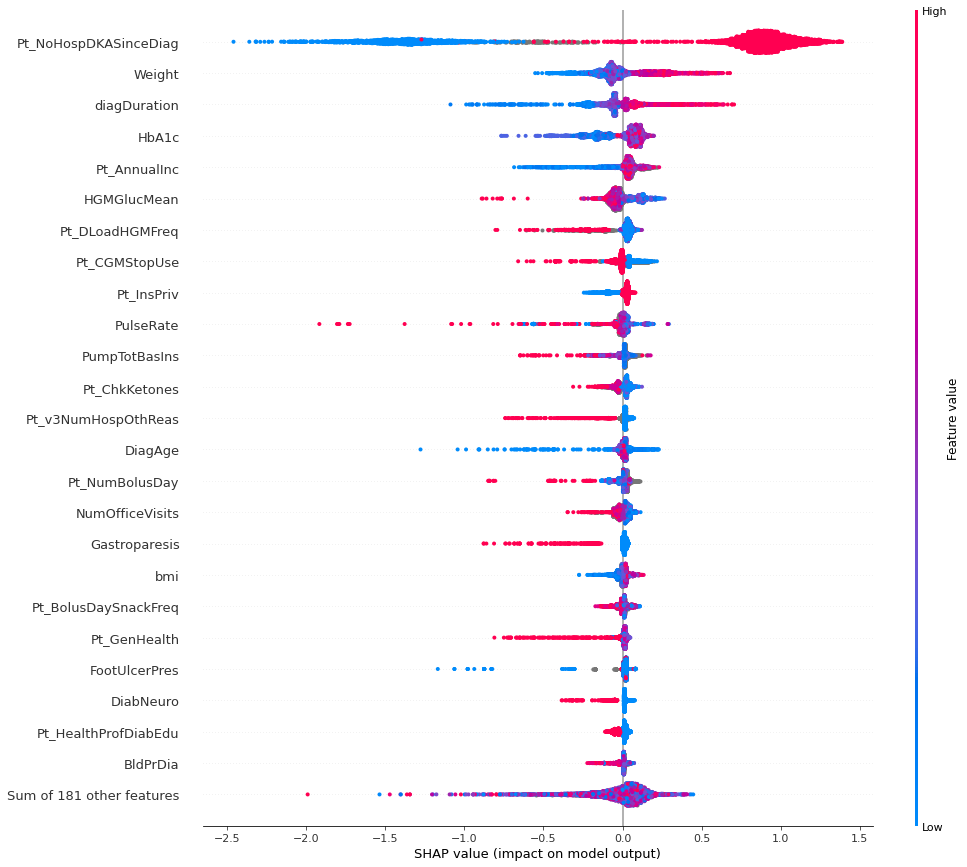

In [43]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_copy)
shap_values = explainer(X_train_copy)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, max_display=25, show=False, plot_size=[15,15])
pl.savefig('dkalocal.png', bbox_inches='tight')

pl.show()


In [44]:
# if is_male:
    
#     X_train.update(X_train[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))

#     X_test.update(X_test[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))
    
# else:
#     X_train.update(X_train[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))

#     X_test.update(X_test[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))
    

In [45]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [46]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [47]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
# select[0] = pd.DataFrame(scaler.fit_transform(X_traiposn))
# select[1] = Y_train
# select[2] = pd.DataFrame(scaler.transform(X_test))


select[0] = pd.DataFrame(X_train)
select[1] = Y_train
select[2] = pd.DataFrame(X_test)



## Feature Selection

In [48]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [49]:
#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
    
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [50]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:34:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA',
       'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay',
       'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk',
       ...
       'CancPancr', 'CancPros', 'CancThyr', 'CancOth', 'Insulin_Glargine',
       'Insulin_Lispro', 'Hydrochlorothiazide', 'Sertraline',
       'Insulin_Aspart_Human', 'diagDuration'],
      dtype='object', length=207)
(6171, 207)


In [52]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [53]:

if('NumDKAOccur' in X_train.columns):
    X_train = X_train.drop(['NumDKAOccur'], axis=1)
    X_test = X_test.drop([ 'NumDKAOccur'], axis=1)
    
if('Pt_NumHospDKA' in X_train.columns):
    X_train = X_train.drop(['Pt_NumHospDKA'], axis=1)
    X_test = X_test.drop([ 'Pt_NumHospDKA'], axis=1)
    
# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train = X_train.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test = X_test.drop([ 'Pt_HospDKASinceDiag'], axis=1)


### Common functions

In [54]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model


In [55]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    return optimal_threshold

In [56]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))   

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

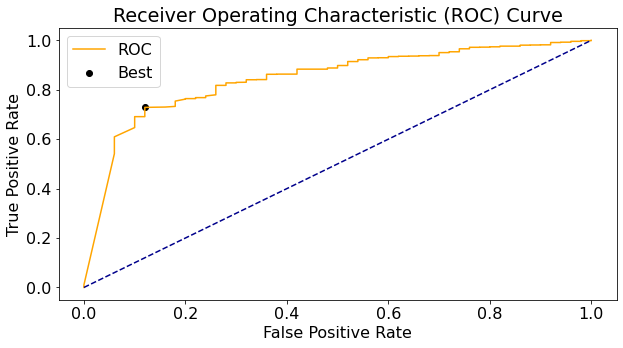

0.9314247431889237
Threshold value is: 0.9836366480239828


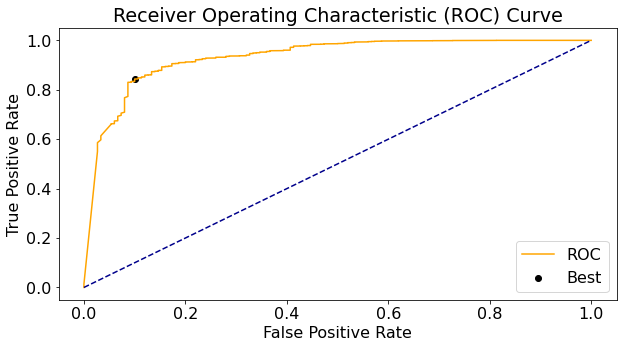


 
 =====================   Train Dataset    ======================
84.52895419187554
              precision    recall  f1-score   support

         0.0       0.16      0.90      0.27       150
         1.0       1.00      0.84      0.91      4478

    accuracy                           0.85      4628
   macro avg       0.58      0.87      0.59      4628
weighted avg       0.97      0.85      0.89      4628



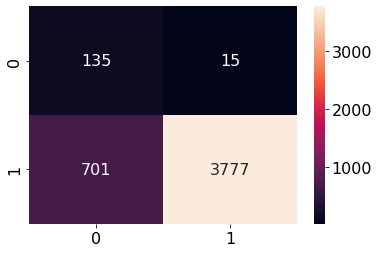

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
73.36357744653273
              precision    recall  f1-score   support

         0.0       0.10      0.88      0.18        50
         1.0       0.99      0.73      0.84      1493

    accuracy                           0.73      1543
   macro avg       0.55      0.80      0.51      1543
weighted avg       0.97      0.73      0.82      1543



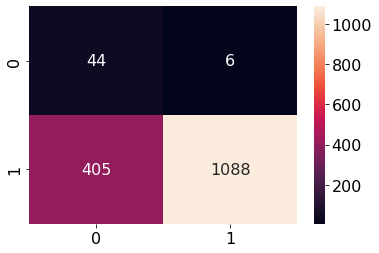

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.8452


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.88       0.72873409]
average accuracy:  0.8043670462156731
f1 0.7336357744653272
f1 0.7336357744653272


In [57]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model = ltb.LGBMClassifier(use_missing = False, 
                         learning_rate = 0.01, 
                         scale_pos_weight=7,
                         max_depth =6, random_state=0 )
# ltb_model.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model)

# pred=ltb_model.predict(X_test)
# pred_train=ltb_model.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)

print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))

<AxesSubplot:>

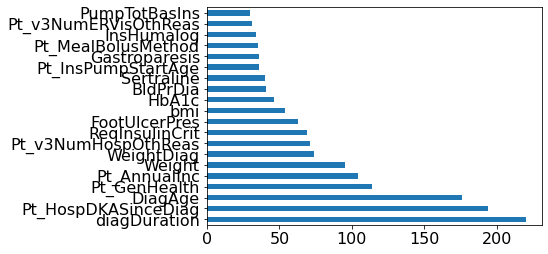

In [58]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [59]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.DKAPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)


    plt.axhline(y=thresh1, color='r')
    plt.axhline(y=thresh2, color = 'g')
    
    plt.axhspan(0.4, thresh1, facecolor='red', alpha=0.05)
    plt.axhspan(thresh1, thresh2, facecolor='yellow', alpha=0.05)
    plt.axhspan(thresh2, 1, facecolor='green', alpha=0.05)


    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()


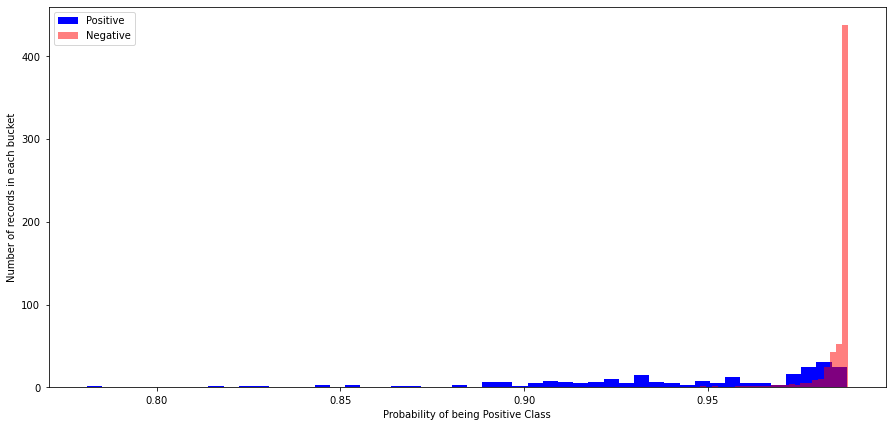

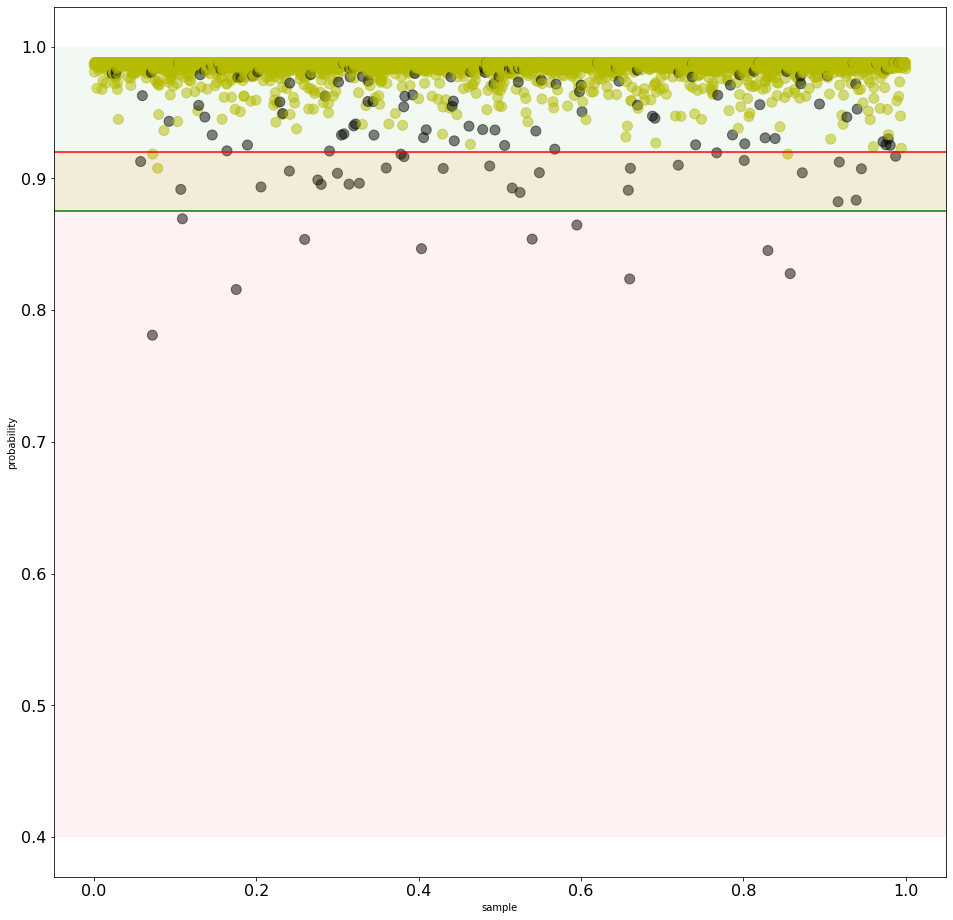

In [60]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.8
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(ltb_model, X_train, 8000, 200)
thresh2 = 0.875
draw_boundary(ltb_model, X_train, Y_train, thresh1, thresh2)


In [61]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [62]:

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (ltb_model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
ltb_model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(ltb_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [0]
actial 1.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [63]:
# compute SHAP values
explainer = shap.TreeExplainer(ltb_model, X_train)
shap_values = explainer(X_train)

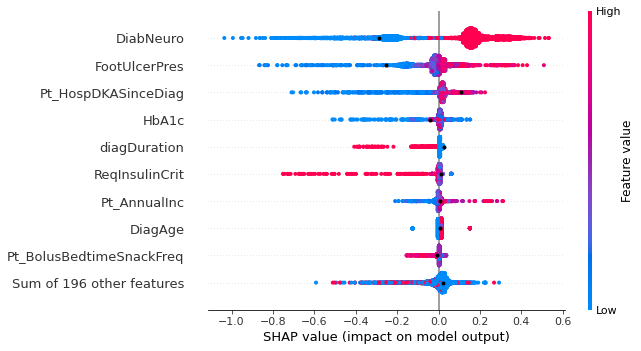

In [64]:
import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

In [65]:
pred = ltb_model.predict_proba(X_train)[:,1] 

Y = pd.DataFrame(Y_train)
X_beeswarm = X_train.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y
X_beeswarm['Y'] = Y[y_label].to_list()

In [66]:
idx = np.where((X_beeswarm['pred']>0.98) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.7) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.6) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(ltb_model, X_beeswarm)
shap_values = explainer(X_beeswarm)



(array([ 127,  326,  482,  630,  670,  711,  723,  933, 1422, 1457, 1476,
       2146, 2225, 2229, 2237, 2367, 2381, 2419, 2444, 2870, 2977, 3097,
       3333, 3412, 3762, 3789, 3949, 4327, 4462, 4516, 4560, 4589, 4607]),)
(array([], dtype=int64),)
(array([], dtype=int64),)


Black = Predict negative , actual positive

Orange = Predict positive , actual positive

Green = Predict positive , actual negative

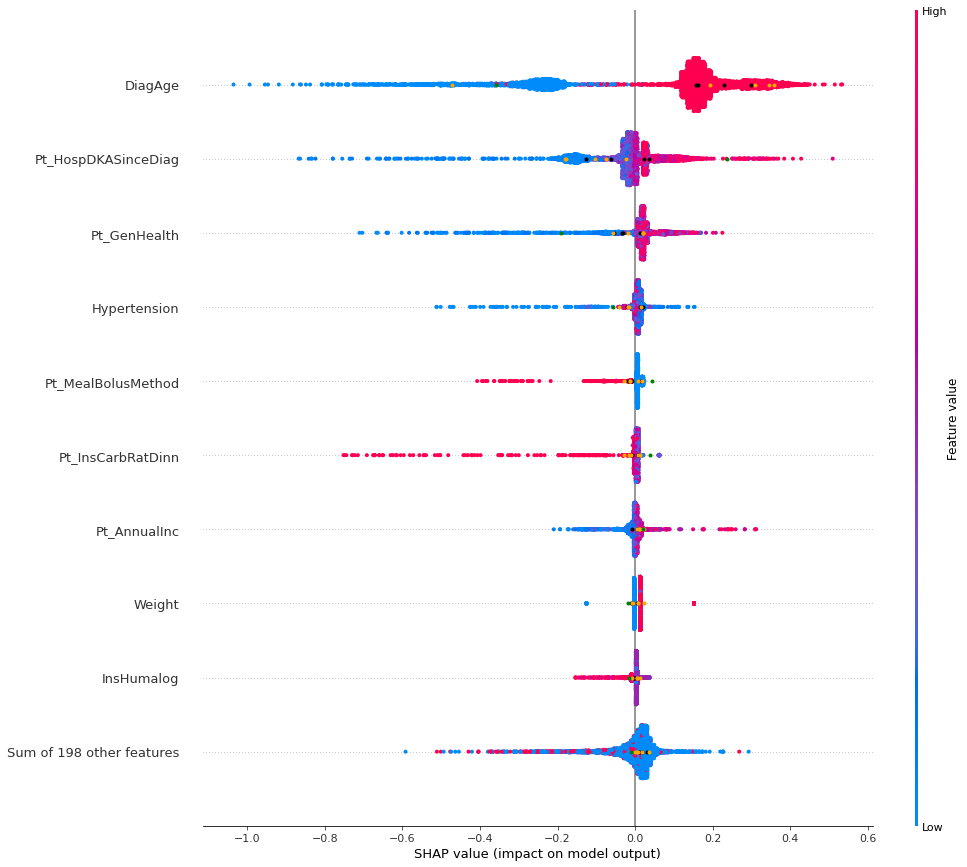

In [67]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[80:81:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[466:467:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[578:579:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1670:1671:], show=False, color="black", plot_size=[15,15])

shap.plots.beeswarm(shap_values[50:51:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[27:28:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[237:238:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[254:255:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[310:311:], show=False, color="orange", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1304:1305:], show=False, color="green", plot_size=[15,15])

plt.show()


Plot shows information-dense summary of how the top features in a dataset impact the model’s output. 

Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. 

Color is used to display the original value of a feature

In the plot HospitalDKA is the most important feature on average, and hospitalDKA = 1 Yes(red) people are more likely to have DKA.


HospitalDKA categories
No: 0,
Yes: 1,
Don\'t know: 2

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.9632829373650108, doublecheck: 0.9632829373650108
Accuracy for the fold no. 2 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 3 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 4 on the test set: 0.9643243243243244, doublecheck: 0.9643243243243244
Accuracy for the fold no. 5 on the test set: 0.96, doublecheck: 0.96
Cross validation mean accuracy 0.9639145408907828
0.8493101138647019
Threshold value is: 0.5123947446868562


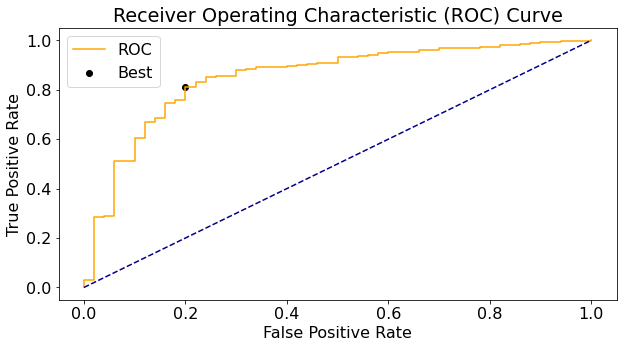

0.935684085157064
Threshold value is: 0.5082514923099235


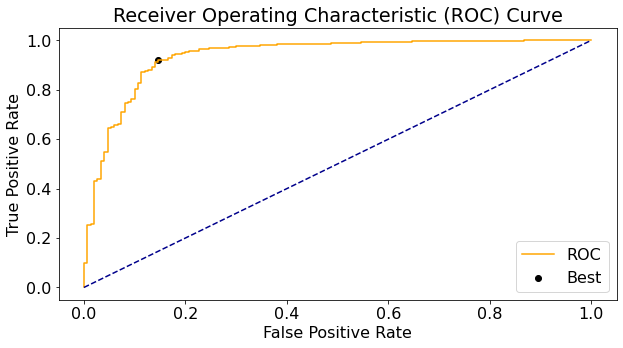


 
 =====================   Train Dataset    ======================
91.94036300777874
              precision    recall  f1-score   support

         0.0       0.27      0.85      0.41       150
         1.0       0.99      0.92      0.96      4478

    accuracy                           0.92      4628
   macro avg       0.63      0.89      0.68      4628
weighted avg       0.97      0.92      0.94      4628



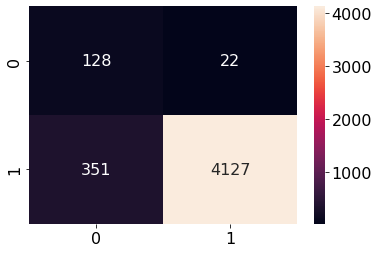

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
81.20544394037589
              precision    recall  f1-score   support

         0.0       0.12      0.80      0.22        50
         1.0       0.99      0.81      0.89      1493

    accuracy                           0.81      1543
   macro avg       0.56      0.81      0.55      1543
weighted avg       0.96      0.81      0.87      1543



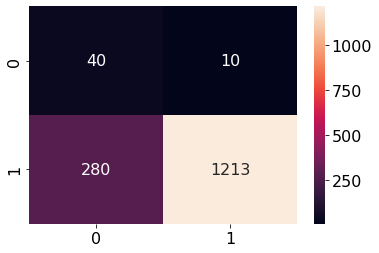

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.8493


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.81245814]
average accuracy:  0.8062290689886136
f1 0.8120544394037589


In [68]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.1,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost,5)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

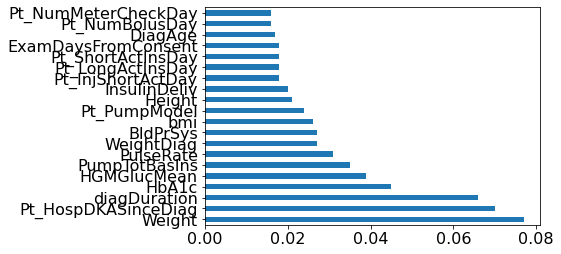

In [69]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 3 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 4 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9719222462203023, doublecheck: 0.9719222462203023
Accuracy for the fold no. 7 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 8 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Cross validation mean accurac

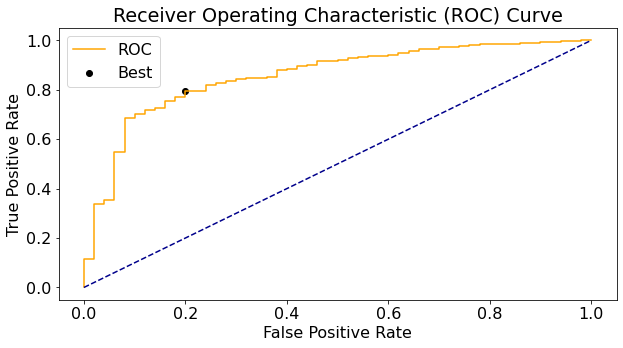

0.9780184606223016
Threshold value is: 1.5268457


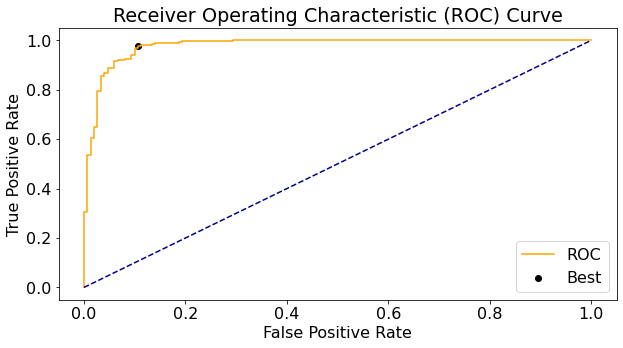


 
 =====================   Train Dataset    ======================
97.5799481417459
              precision    recall  f1-score   support

         0.0       0.58      0.89      0.71       150
         1.0       1.00      0.98      0.99      4478

    accuracy                           0.98      4628
   macro avg       0.79      0.94      0.85      4628
weighted avg       0.98      0.98      0.98      4628



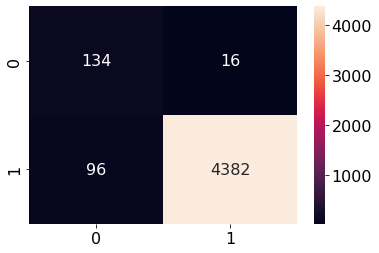

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
79.45560596241089
              precision    recall  f1-score   support

         0.0       0.12      0.80      0.20        50
         1.0       0.99      0.79      0.88      1493

    accuracy                           0.79      1543
   macro avg       0.55      0.80      0.54      1543
weighted avg       0.96      0.79      0.86      1543



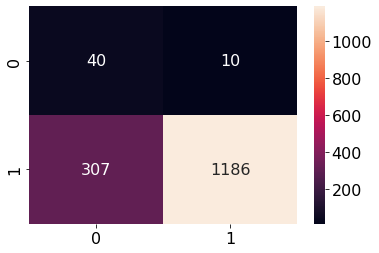

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.8559


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.79437374]
average accuracy:  0.7971868720696584
f1 0.7945560596241088


In [70]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

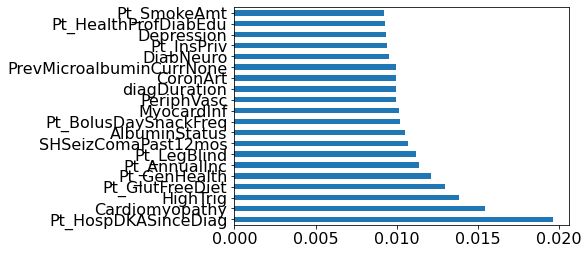

In [71]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

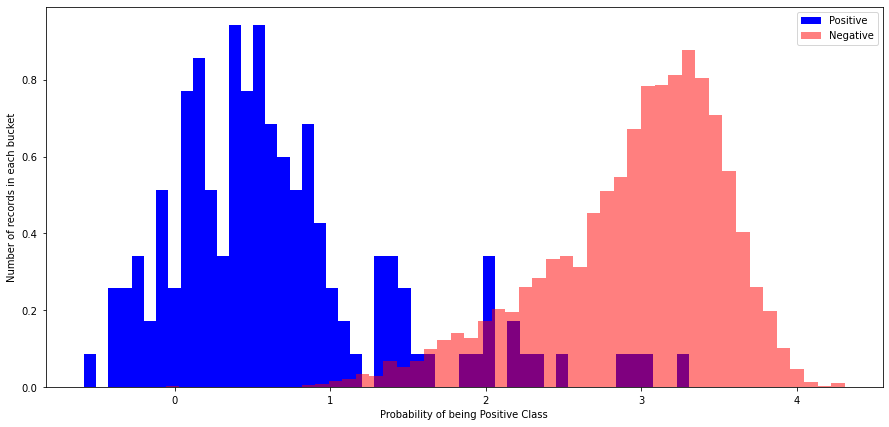

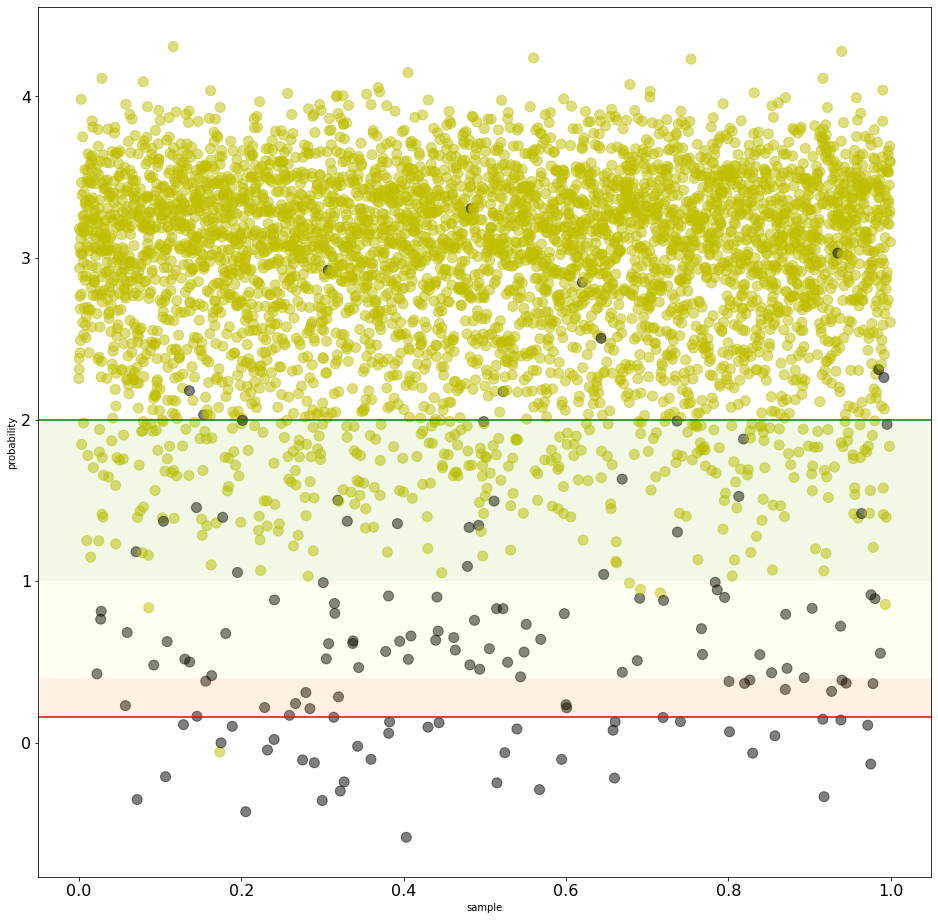

In [72]:
thresh1 = get_optimal_threshold(xgb_impute, X_train, 8000, 200)
thresh2 = 2.0
draw_boundary(xgb_impute, X_train, Y_train, thresh1, thresh2)

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.8315334773218143, doublecheck: 0.8315334773218143
Accuracy for the fold no. 2 on the test set: 0.8272138228941684, doublecheck: 0.8272138228941684
Accuracy for the fold no. 3 on the test set: 0.8444924406047516, doublecheck: 0.8444924406047516
Accuracy for the fold no. 4 on the test set: 0.8617710583153347, doublecheck: 0.8617710583153347
Accuracy for the fold no. 5 on the test set: 0.896328293736501, doublecheck: 0.896328293736501
Accuracy for the fold no. 6 on the test set: 0.8401727861771058, doublecheck: 0.8401727861771058
Accuracy for the fold no. 7 on the test set: 0.8466522678185745, doublecheck: 0.8466522678185745
Accuracy for the fold no. 8 on the test set: 0.857451403887689, doublecheck: 0.857451403887689
Accuracy for the fold no. 9 on the test set: 0.8593073593073594, doublecheck: 0.8593073593073594
Accuracy for the fold no. 10 on the test set: 0.8658008658008658, doublecheck: 0.8658008658008658
Cross validation mean accuracy 0.

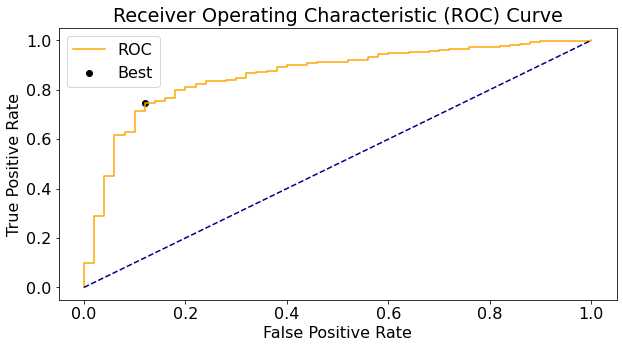

0.907515259788596
Threshold value is: 0.5058147810851952


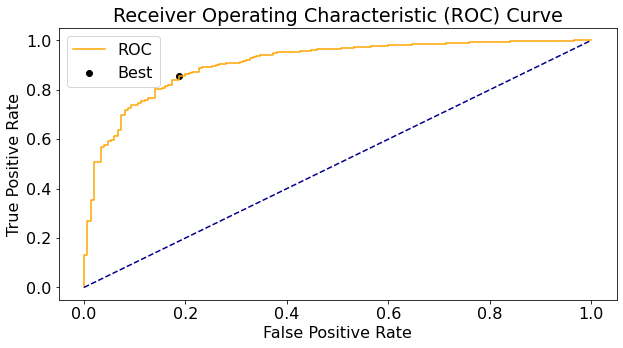


 
 =====================   Train Dataset    ======================
85.32843560933449
              precision    recall  f1-score   support

         0.0       0.16      0.81      0.26       150
         1.0       0.99      0.85      0.92      4478

    accuracy                           0.85      4628
   macro avg       0.58      0.83      0.59      4628
weighted avg       0.97      0.85      0.90      4628



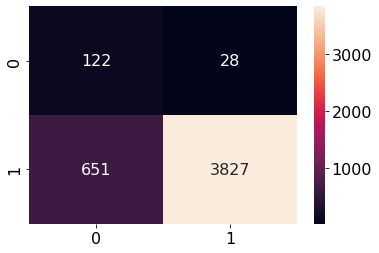

Accuracy of on training set: 0.86


 =====================   Test Dataset    =======================
75.24303305249514
              precision    recall  f1-score   support

         0.0       0.10      0.88      0.19        50
         1.0       0.99      0.75      0.85      1493

    accuracy                           0.75      1543
   macro avg       0.55      0.81      0.52      1543
weighted avg       0.97      0.75      0.83      1543



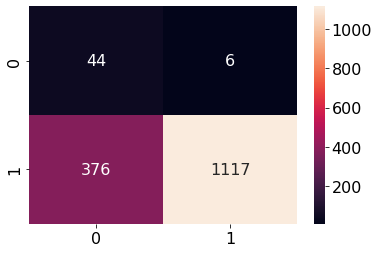

Accuracy of classifier on test set: 0.87


 =======================   Test-ROC    =========================
roc_auc = 0.861


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.88       0.74815807]
average accuracy:  0.8140790354989953
f1 0.7524303305249513


In [73]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=4,
                             n_estimators = feature,
                             criterion = 'gini', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

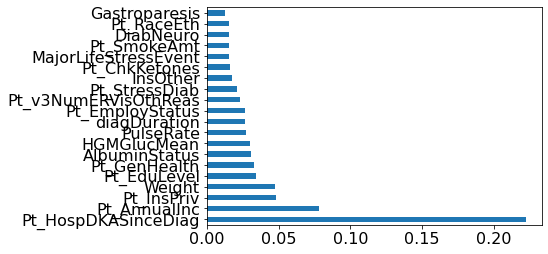

In [74]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.7537796976241901, doublecheck: 0.7537796976241901


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 2 on the test set: 0.7321814254859611, doublecheck: 0.7321814254859611


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.7451403887688985, doublecheck: 0.7451403887688985


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 4 on the test set: 0.734341252699784, doublecheck: 0.734341252699784


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.7300215982721382, doublecheck: 0.7300215982721382


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 6 on the test set: 0.7300215982721382, doublecheck: 0.7300215982721382


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.7688984881209503, doublecheck: 0.7688984881209503


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 8 on the test set: 0.755939524838013, doublecheck: 0.755939524838013


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 9 on the test set: 0.7705627705627706, doublecheck: 0.7705627705627706
Accuracy for the fold no. 10 on the test set: 0.7554112554112554, doublecheck: 0.7554112554112554
Cross validation mean accuracy 0.7476298000056099
0.7098325519089083
Threshold value is: 0.5913570328029841


The max_iter was reached which means the coef_ did not converge


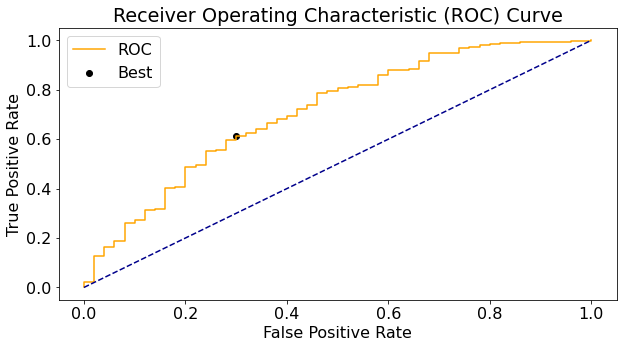

0.8239660562751229
Threshold value is: 0.5030162706892202


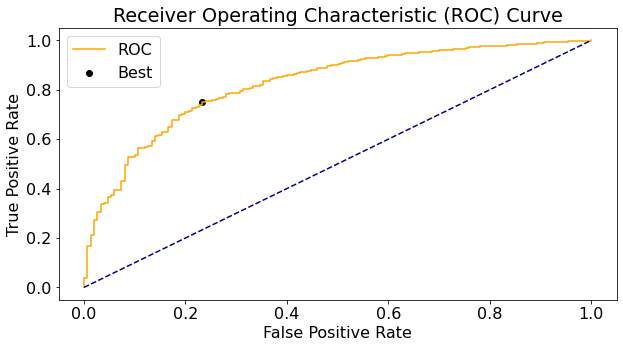


 
 =====================   Train Dataset    ======================
75.25929127052723
              precision    recall  f1-score   support

         0.0       0.09      0.77      0.17       150
         1.0       0.99      0.75      0.85      4478

    accuracy                           0.75      4628
   macro avg       0.54      0.76      0.51      4628
weighted avg       0.96      0.75      0.83      4628



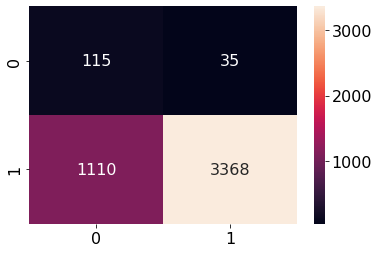

Accuracy of on training set: 0.76


 =====================   Test Dataset    =======================
61.697990926766046
              precision    recall  f1-score   support

         0.0       0.06      0.70      0.11        50
         1.0       0.98      0.61      0.76      1493

    accuracy                           0.62      1543
   macro avg       0.52      0.66      0.43      1543
weighted avg       0.95      0.62      0.74      1543



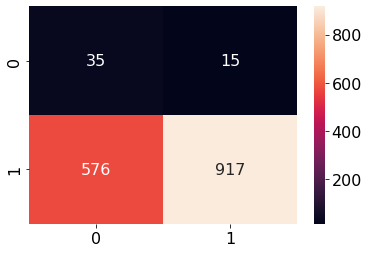

Accuracy of classifier on test set: 0.75


 =======================   Test-ROC    =========================
roc_auc = 0.7098


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.7       0.6141996]
average accuracy:  0.6570997990622907
f1 0.6169799092676604


In [75]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

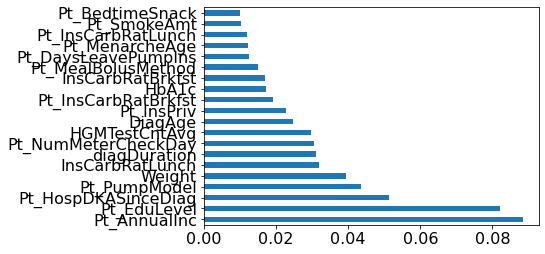

In [76]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9568034557235421, doublecheck: 0.9568034557235421
Accuracy for the fold no. 2 on the test set: 0.9460043196544277, doublecheck: 0.9460043196544277
Accuracy for the fold no. 3 on the test set: 0.9481641468682506, doublecheck: 0.9481641468682506
Accuracy for the fold no. 4 on the test set: 0.9568034557235421, doublecheck: 0.9568034557235421
Accuracy for the fold no. 5 on the test set: 0.9395248380129589, doublecheck: 0.9395248380129589
Accuracy for the fold no. 6 on the test set: 0.9568034557235421, doublecheck: 0.9568034557235421
Accuracy for the fold no. 7 on the test set: 0.9568034557235421, doublecheck: 0.9568034557235421
Accuracy for the fold no. 8 on the test set: 0.9438444924406048, doublecheck: 0.9438444924406048
Accuracy for the fold no. 9 on the test set: 0.9545454545454546, doublecheck: 0.9545454545454546
Accuracy for the fold no. 10 on the test set: 0.9523809523809523, doublecheck: 0.9523809523809523
Cross validation mean accurac

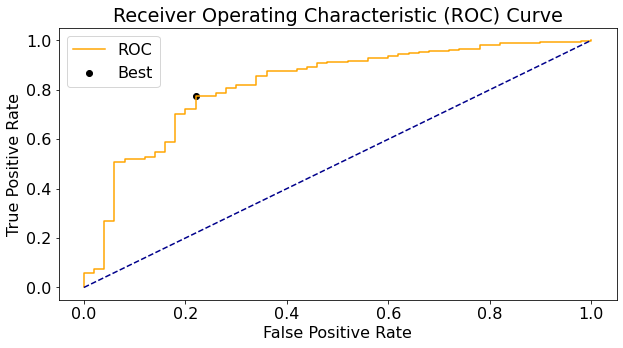

0.8911210361768648
Threshold value is: 0.9692837067918437


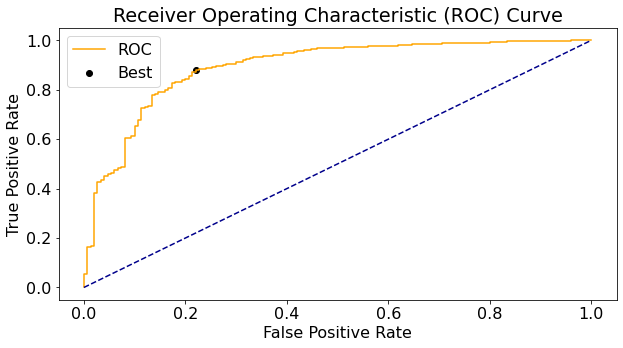


 
 =====================   Train Dataset    ======================
87.66205704407952
              precision    recall  f1-score   support

         0.0       0.18      0.78      0.29       150
         1.0       0.99      0.88      0.93      4478

    accuracy                           0.88      4628
   macro avg       0.59      0.83      0.61      4628
weighted avg       0.97      0.88      0.91      4628



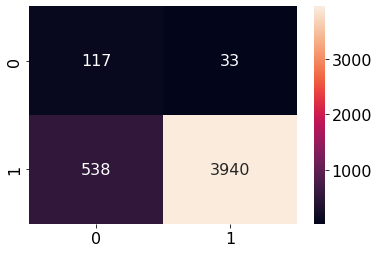

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
77.64095917044718
              precision    recall  f1-score   support

         0.0       0.10      0.78      0.18        50
         1.0       0.99      0.78      0.87      1493

    accuracy                           0.78      1543
   macro avg       0.55      0.78      0.53      1543
weighted avg       0.96      0.78      0.85      1543



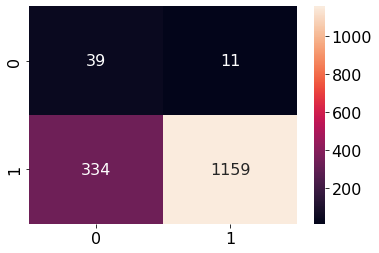

Accuracy of classifier on test set: 0.95


 =======================   Test-ROC    =========================
roc_auc = 0.8195


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78       0.77628935]
average accuracy:  0.7781446751507033
f1 0.7764095917044718


In [77]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

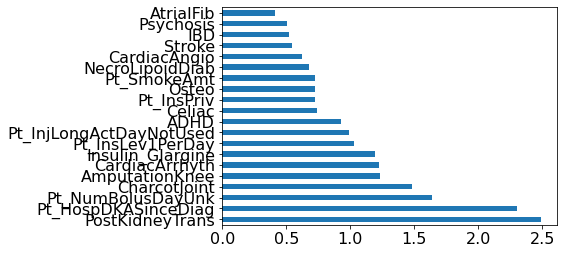

In [78]:
feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')


## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9632829373650108, doublecheck: 0.9632829373650108
Accuracy for the fold no. 3 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

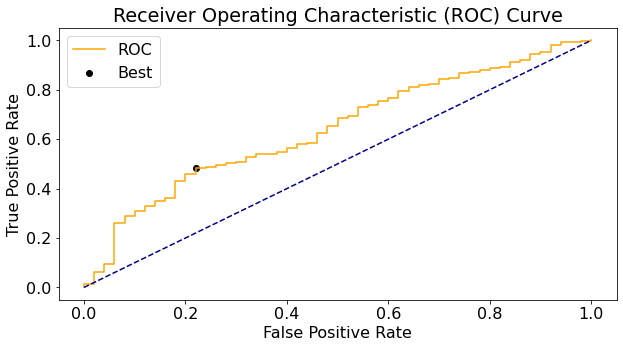

0.6679991067440821
Threshold value is: 0.9704132516367321


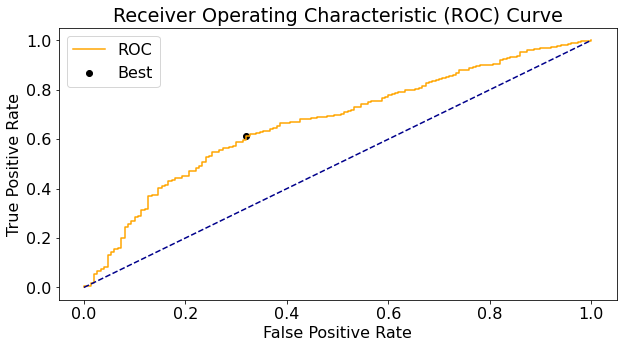


 
 =====================   Train Dataset    ======================
61.646499567847876
              precision    recall  f1-score   support

         0.0       0.06      0.68      0.10       150
         1.0       0.98      0.61      0.76      4478

    accuracy                           0.62      4628
   macro avg       0.52      0.65      0.43      4628
weighted avg       0.95      0.62      0.73      4628



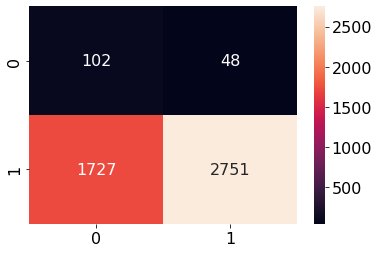

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
49.38431626701231
              precision    recall  f1-score   support

         0.0       0.05      0.78      0.09        50
         1.0       0.99      0.48      0.65      1493

    accuracy                           0.49      1543
   macro avg       0.52      0.63      0.37      1543
weighted avg       0.95      0.49      0.63      1543



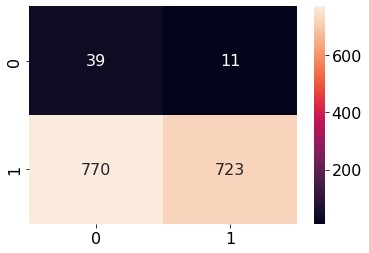

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6403


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78       0.48425988]
average accuracy:  0.6321299397186873
f1 0.4938431626701231


In [79]:

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

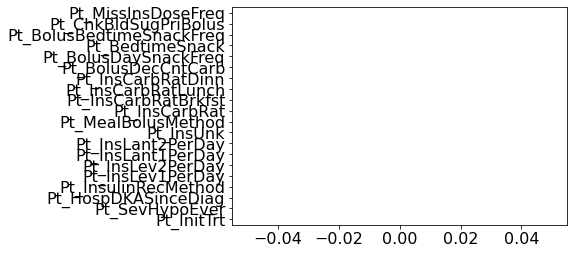

In [80]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9632829373650108, doublecheck: 0.9632829373650108
Accuracy for the fold no. 8 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 9 on the test set: 0.9718614718614719, doublecheck: 0.9718614718614719
Accuracy for the fold no. 10 on the test set: 0.9632034632034632, doublecheck: 0.9632034632034632
Cross validation mean accurac

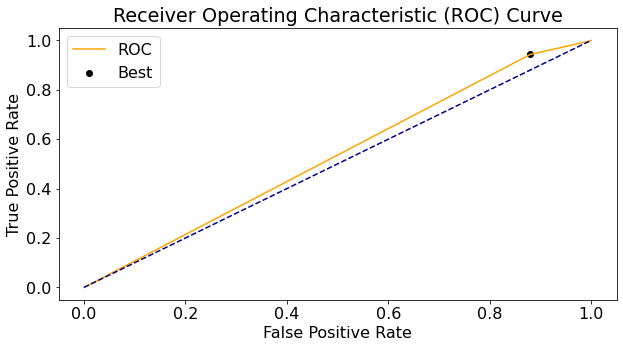

0.9791670388566324
Threshold value is: 1.0


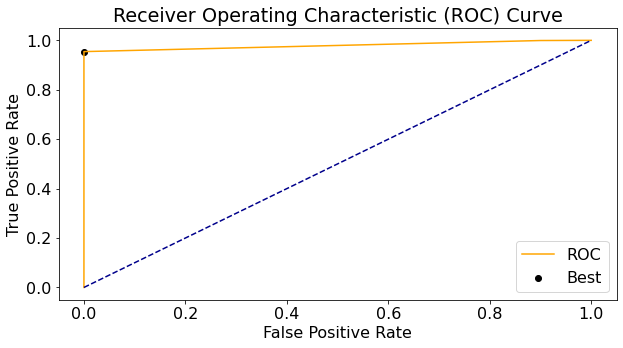


 
 =====================   Train Dataset    ======================
95.59204840103716
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.60       150
         1.0       1.00      0.95      0.98      4478

    accuracy                           0.96      4628
   macro avg       0.71      0.98      0.79      4628
weighted avg       0.98      0.96      0.96      4628



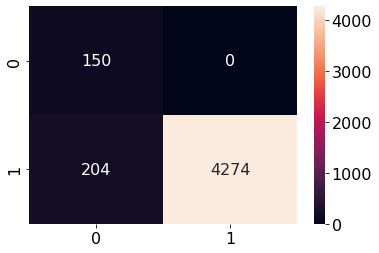

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
91.63966299416721
              precision    recall  f1-score   support

         0.0       0.07      0.12      0.09        50
         1.0       0.97      0.94      0.96      1493

    accuracy                           0.92      1543
   macro avg       0.52      0.53      0.52      1543
weighted avg       0.94      0.92      0.93      1543



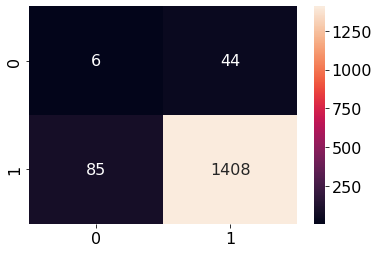

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.5315


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.12       0.94306765]
average accuracy:  0.5315338245144006
f1 0.916396629941672


In [81]:
from sklearn.neighbors import KNeighborsClassifier
gnb =  KNeighborsClassifier(n_neighbors=3)
gnb = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

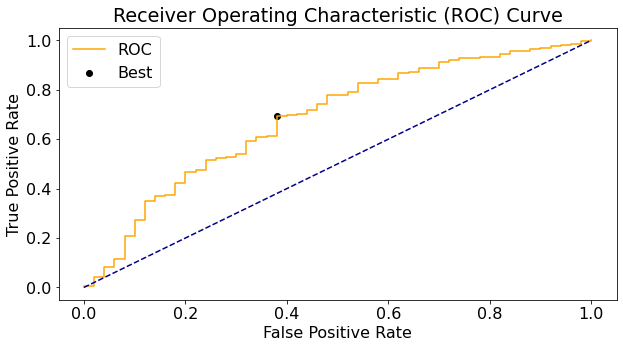

0.9216778323656394
Threshold value is: 0.9654899555316921


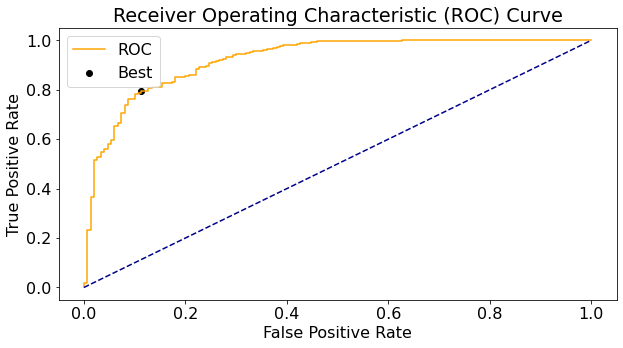


 
 =====================   Train Dataset    ======================
79.68885047536733
              precision    recall  f1-score   support

         0.0       0.13      0.89      0.22       150
         1.0       1.00      0.79      0.88      4478

    accuracy                           0.80      4628
   macro avg       0.56      0.84      0.55      4628
weighted avg       0.97      0.80      0.86      4628



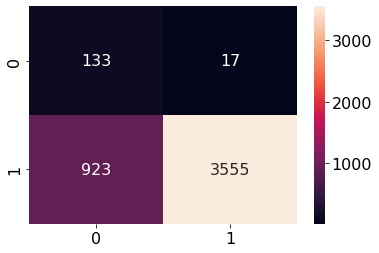

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
69.02138690861958
              precision    recall  f1-score   support

         0.0       0.06      0.62      0.11        50
         1.0       0.98      0.69      0.81      1493

    accuracy                           0.69      1543
   macro avg       0.52      0.66      0.46      1543
weighted avg       0.95      0.69      0.79      1543



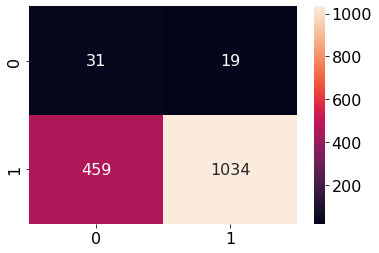

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6831


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.62      0.6925653]
average accuracy:  0.656282652377763
f1 0.6902138690861958


In [82]:
from sklearn import svm
gnb =  svm.SVC(probability=True)
gnb = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


In [83]:
d = pd.DataFrame(Y_test).head(100)
# s = d[d.DKAPast12mos == 0.0]
# for index, row in d.iterrows():
#     if row.DKAPast12mos == 0.0:
#         print(index)
d      

DKAPast12mos
1184            1.0
23974           1.0
6461            1.0
22322           1.0
24984           1.0
11883           1.0
14907           1.0
5992            1.0
1530            1.0
271             1.0
13767           1.0
23509           1.0
5460            1.0
9947            1.0
13316           1.0
15945           1.0
20984           1.0
22738           1.0
13252           1.0
17552           1.0
13509           1.0
22500           1.0
12300           1.0
8949            1.0
14151           1.0
11628           1.0
5160            1.0
17481           1.0
7559            1.0
2646            1.0
15093           1.0
8305            1.0
17119           1.0
19697           1.0
2631            1.0
18159           1.0
16709           1.0
4653            1.0
4484            1.0
6646            1.0
4140            1.0
24318           1.0
8904            1.0
5248            0.0
9398            1.0
21947           1.0
18763           1.0
18372           1.0
7099            1.0
8824            1.0
24461           1.0
329             1.0
6859            1.0
18539           1.0
19251           1.0
4144            1.0
17301           1.0
10816           1.0
23431           1.0
9803            1.0
12331           1.0
3274            1.0
4583            1.0
659             1.0
19812           1.0
15907           1.0
3709            1.0
3477            1.0
2685            1.0
12286           1.0
17004           1.0
4947            1.0
8441            1.0
21446           1.0
683             1.0
19771           1.0
2743            1.0
14735           1.0
300             1.0
22547           1.0
5195            1.0
2917            1.0
21122           1.0
15871           1.0
1750            1.0
4055            1.0
14059           1.0
10047           1.0
19107           1.0
10525           1.0
13892           1.0
13064           1.0
9110            1.0
3070            1.0
695             1.0
17335           1.0
16731           1.0
23108           1.0
7678            0.0
19301           1.0

## SHAP Values

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


my_model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = my_model.predict(data_for_prediction_array)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
my_model.predict_proba(data_for_prediction_array)

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)


shap.initjs()

# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

predictoin [1.]
actial 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


NOTE: How do you interpret shap

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from weight being -0.9503. Though the pt_hospDKASinceDiag value has a meaningful effect decreasing the prediction.